# Прогнозирование оттока клиентов

# Этапы работы

[1. Описание данных](#step0)
[2. Подготовка данных](#step1)
- [знакомство с данными](#step1.1)
- [подготовка данных](#step1.2)

[2. Обучение моделей без учета дисбаланса](#step2)
- [решающее дерево](#step2.1)
- [случайный лес](#step2.2)
- [логистическая регрессия](#step2.3)

[3. Борьа с дисбалансом](#step3)
- [class_weight](#step3.1)
- [upsampling](#step3.2)
- [downsampling](#step3.3)

[4. Тестирование модели](#step4)

# Описание данных <a id='step0'></a>

## Признаки
- **RowNumber** — индекс строки в данных
- **CustomerId** — уникальный идентификатор клиента
- **Surname** — фамилия
- **CreditScore** — кредитный рейтинг
- **Geography** — страна проживания
- **Gender** — пол
- **Age** — возраст
- **Tenure** — количество недвижимости у клиента
- **Balance** — баланс на счёте
- **NumOfProducts** — количество продуктов банка, используемых клиентом
- **HasCrCard** — наличие кредитной карты
- **IsActiveMember** — активность клиента
- **EstimatedSalary** — предполагаемая зарплата

## Целевой признак

- **Exited** — факт ухода клиента

# Шаг 1. Подготовка данных <a id='step1'></a>

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


## Знакомство с данными <a id='step1.1'></a>

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.shape

(10000, 14)

In [4]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
data.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

На первый взгляд не обнаружено каких-то несоответствий или нарушений логики в данных (например возвраст от min = 18 до max = 92 - вполне подходит под задачу, или в столбце Gender мы видим только два уникальных значения, это исключает наличие дубликатов, например, Male и male). То есть с данными все нормально.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


- Есть категориальные признаки, которые необходимо преобразовать в численные - Gender, Geography. 
- Признаки - RowNumber, CustomerId, Surname - ничего не значащие признаки, в обучении модели использовать не будем.
- Tenure - есть пропуски 9%. Можно предположить, что если не заполнено, то недвижимости нет, и заполнить нулями. Либо вообще удалить, чтобы не исказить результаты.

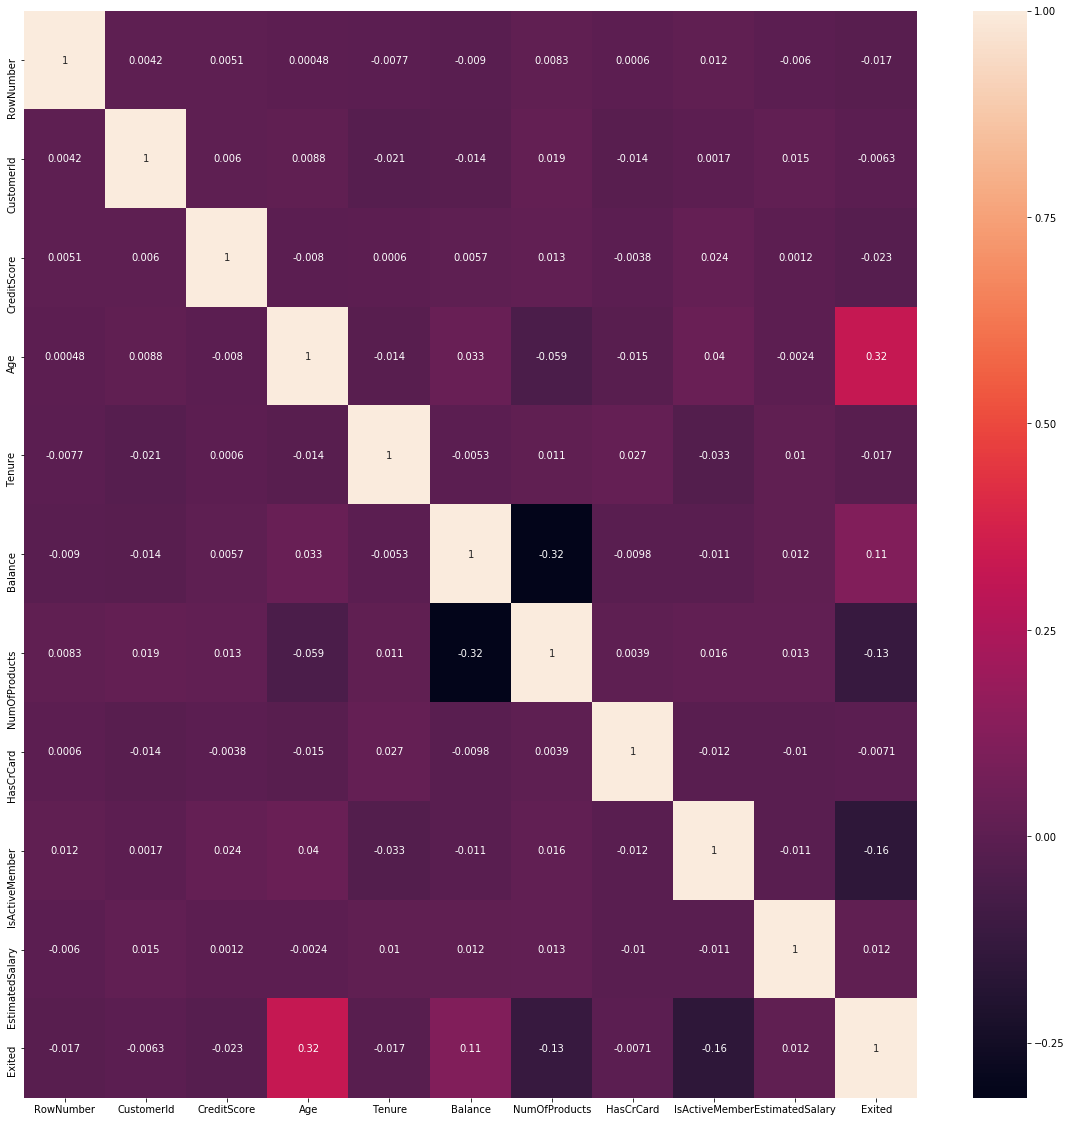

In [7]:
parameters = data
plt.figure(figsize = (20,20))
sns.heatmap(parameters.corr(method='spearman'),annot=True)

Очень сильной зависимости между признаками нет - мультиколлинеарность не обнаружена.

## Подготовка данных <a id='step1.2'></a>

Применим технику прямого кодирования (OHE) для преобразования категориальных признаков в численные

In [8]:
data['gender_ohe']=pd.get_dummies(data['Gender'], drop_first=True)
data[['Germany','Spain']] = pd.get_dummies(data['Geography'], drop_first=True)
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,gender_ohe,Germany,Spain
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1


Удалим строки с пропусками

In [9]:
data=data.dropna()
data.shape

(9091, 17)

Поделим выборку на обучающую, валидационную и тестовую, сначала удалив ненужные столбцы

In [10]:
data = data.drop(['RowNumber','CustomerId','Surname','Gender','Geography'], axis=1)

In [11]:
features = data.drop(['Exited'], axis=1)
target = data['Exited']
features_train, features_inter, target_train, target_inter = train_test_split(features, target, test_size=0.40, random_state=12345, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_inter,target_inter, test_size=0.50, random_state=12345, stratify=target_inter)

Получили три выборки:

data_train - обучающая - 5454 объекта,
data_valid - валидационная - 1818 объектов, для проверки качества моделей и выбора наилучшей
data_test - тестовая - 1819 объектов, для окончательной проверки качества выбранной модели

# Шаг 2. Исследование задачи <a id='step2'></a>

В нашей задаче будем использовать три алгоритма классификации: DecisionTreeClassifier, RandomForestClassifier, LogisticRegression. Нам предстоит: обучение, подбор гиперпарметров, оценка качества моделей и выбор наилучшей. Пока что без учета дисбаланса классов.

In [12]:
features_test = features_test.astype(int)
features_valid = features_valid.astype(int)
features_train = features_train.astype(int)

In [13]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


Соотношение классов - примерно 1:4. Наблюдаем дисбаланс, хоть и не 1 к 10, но все-таки есть. Попробуем обучить модели без учета дисбаланса классов.

- **решающее дерево** <a id='step2.1'></a>

Обучение модели и проверка качества модели на валидационной выборке с разной глубиной дерева

In [14]:
score_DecisionTree = pd.DataFrame(columns = ['depth', 'f1_score','auc_roc'])
i = 0
for depth in range(2, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    model.fit(features_train, target_train)
    valid_predictions = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    score_DecisionTree.loc[i] = [depth, f1_score(target_valid,valid_predictions),roc_auc_score(target_valid, probabilities_one_valid)]
    i=i+1

score_DecisionTree

,depth,f1_score,auc_roc
0,2.0,0.524046,0.730402
1,3.0,0.520868,0.787129
2,4.0,0.512727,0.811352
3,5.0,0.573379,0.845047
4,6.0,0.579760,0.839770
5,7.0,0.587248,0.828032
6,8.0,0.552980,0.810342
7,9.0,0.546952,0.789347


Целевое значание метрики F1 не достигнуто (должно быть не менее 0.59). Маскимальное значение метрики F1 = 0,577, auc_roc = 0.849, и достигнуты они при разных гиперпараметрах.

- **случайный лес** <a id='step2.2'></a>

Обучение модели и проверка качества модели на валидационной выборке с разным значением n_estimator

In [15]:

score_RandomForest = pd.DataFrame(columns = ['n_estimators','depth','f1_score','auc_roc'])
i=0
for n in range(10, 70, 10):
    for depth in range(5,16):
        model = RandomForestClassifier(random_state=12345, n_estimators=n,max_depth=depth)
        model.fit(features_train, target_train)
        valid_predictions = model.predict(features_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        score_RandomForest.loc[i] = [n, depth, f1_score(target_valid,valid_predictions),roc_auc_score(target_valid, probabilities_one_valid)]
        i=i+1

In [16]:
score_RandomForest.loc[score_RandomForest['f1_score'] == score_RandomForest['f1_score'].max()]


,n_estimators,depth,f1_score,auc_roc
31,30.0,14.0,0.617647,0.865332
53,50.0,14.0,0.617647,0.871380


In [17]:
score_RandomForest.loc[score_RandomForest['auc_roc'] == score_RandomForest['auc_roc'].max()]

,n_estimators,depth,f1_score,auc_roc
14,20.0,8.0,0.588034,0.879625


Максимальное значение метрики f1 = 0.591973 (целевое значение достигнуто) при гиперпараметрах n_estimators=30 и max_depth=13. А максимальный auc_roc=0.87 достигнут при n_estimators=6 и max_depth=9.

- **логистическая регрессия** <a id='step2.3'></a>

Обучение модели и проверка качества модели на валидационной выборке

In [18]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
valid_predictions = model.predict(features_valid)
f1_score(target_valid,valid_predictions)

0.3306772908366534

Целевое значение метрики F1 не достигнуто.

Из всех алгоритмов наилучшая метрика качества F1 у алгоритма RandomForestClassifier. Попробуем улучшить качество метрики, учитывая дисбаланс классов.

# Шаг 3. Борьба с дисбалансом <a id='step3'></a>

Способы борьбы с дисбалансом
- class_weight - взвешивание классов
- upsampling - увеличение выборки
- downsampling - уменьшение выборки

Попробуем все способы.

- **class_weight** <a id='step3.1'></a>

Повторим обучение моделей и подбор гиперпарметров, но уже с параметром class_weight='balanced'

In [19]:
score_DecisionTree = pd.DataFrame(columns = ['depth', 'f1_score','auc_roc'])
i = 0
for depth in range(2, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth,class_weight='balanced')
    model.fit(features_train, target_train)
    valid_predictions = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    score_DecisionTree.loc[i] = [depth, f1_score(target_valid,valid_predictions),roc_auc_score(target_valid, probabilities_one_valid)]
    i=i+1

score_DecisionTree

,depth,f1_score,auc_roc
0,2.0,0.537613,0.769614
1,3.0,0.537613,0.812301
2,4.0,0.552268,0.827650
3,5.0,0.571148,0.846642
4,6.0,0.583085,0.835516
5,7.0,0.562804,0.832036
6,8.0,0.577873,0.817913
7,9.0,0.552106,0.786410


In [20]:
score_RandomForest = pd.DataFrame(columns = ['n_estimators','depth','f1_score','auc_roc'])
i=0
for n in range(10, 70, 10):
    for depth in range(5,16):
        model = RandomForestClassifier(random_state=12345, n_estimators=n,max_depth=depth, class_weight='balanced')
        model.fit(features_train, target_train)
        valid_predictions = model.predict(features_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        score_RandomForest.loc[i] = [n, depth, f1_score(target_valid,valid_predictions),roc_auc_score(target_valid, probabilities_one_valid)]
        i=i+1

In [21]:
score_RandomForest.loc[score_RandomForest['f1_score'] == score_RandomForest['f1_score'].max()]

,n_estimators,depth,f1_score,auc_roc
36,40.0,8.0,0.648846,0.878822


In [22]:
model = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')
model.fit(features_train, target_train)
valid_predictions = model.predict(features_valid)
f1_score(target_valid,valid_predictions)

0.5065420560747663

Метрика F1 улучшилась. Наибольшее значение метрики f1 у RandomForest при параметрах n_estimators=40.0, max_depth=9.0.

- **upsampling** <a id='step3.2'></a>

Повторим обучение моделей и подбор гиперпарметров, но уже с увеличенной выборкой.

In [23]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled


In [24]:
features_up, target_up = upsample(features_train, target_train, 4)

In [25]:
score_DecisionTree = pd.DataFrame(columns = ['depth', 'f1_score','auc_roc'])
i = 0
for depth in range(2, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    model.fit(features_up, target_up)
    valid_predictions = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    score_DecisionTree.loc[i] = [depth, f1_score(target_valid,valid_predictions),roc_auc_score(target_valid, probabilities_one_valid)]
    i=i+1

score_DecisionTree

,depth,f1_score,auc_roc
0,2.0,0.537613,0.769614
1,3.0,0.537613,0.812301
2,4.0,0.552268,0.827650
3,5.0,0.571148,0.846642
4,6.0,0.583085,0.835516
5,7.0,0.562257,0.831389
6,8.0,0.576635,0.818158
7,9.0,0.556656,0.792972


In [26]:
score_RandomForest = pd.DataFrame(columns = ['n_estimators','depth','f1_score','auc_roc'])
i=0
for n in range(10, 70, 10):
    for depth in range(5,16):
        model = RandomForestClassifier(random_state=12345, n_estimators=n,max_depth=depth)
        model.fit(features_up, target_up)
        valid_predictions = model.predict(features_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        score_RandomForest.loc[i] = [n, depth, f1_score(target_valid,valid_predictions),roc_auc_score(target_valid, probabilities_one_valid)]
        i=i+1

In [27]:
score_RandomForest.loc[score_RandomForest['f1_score'] == score_RandomForest['f1_score'].max()]

,n_estimators,depth,f1_score,auc_roc
64,60.0,14.0,0.644628,0.866949


In [28]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_up, target_up)
valid_predictions = model.predict(features_valid)
f1_score(target_valid,valid_predictions)

0.5050878815911193

Метрики F1 улучшились, но не так сильно как при использовании метода "взвешивание классов"

- **downsampling** <a id='step3.3'></a>

Повторим обучение и подбор гиперпарметров на уменьшенной выборке:

In [29]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_down, target_down = downsample(features_train, target_train, 0.25)

In [30]:
score_DecisionTree = pd.DataFrame(columns = ['depth', 'f1_score','auc_roc'])
i = 0
for depth in range(2, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    model.fit(features_down, target_down)
    valid_predictions = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    score_DecisionTree.loc[i] = [depth, f1_score(target_valid,valid_predictions),roc_auc_score(target_valid, probabilities_one_valid)]
    i=i+1

score_DecisionTree

,depth,f1_score,auc_roc
0,2.0,0.537613,0.769614
1,3.0,0.537613,0.813772
2,4.0,0.556539,0.825433
3,5.0,0.562620,0.845540
4,6.0,0.568844,0.845638
5,7.0,0.568627,0.834892
6,8.0,0.555556,0.803694
7,9.0,0.521916,0.772440


In [31]:
score_RandomForest = pd.DataFrame(columns = ['n_estimators','depth','f1_score','auc_roc'])
i=0
for n in range(10, 70, 10):
    for depth in range(5,16):
        model = RandomForestClassifier(random_state=12345, n_estimators=n,max_depth=depth)
        model.fit(features_down, target_down)
        valid_predictions = model.predict(features_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        score_RandomForest.loc[i] = [n, depth, f1_score(target_valid,valid_predictions),roc_auc_score(target_valid, probabilities_one_valid)]
        i=i+1

In [32]:
score_RandomForest.loc[score_RandomForest['f1_score'] == score_RandomForest['f1_score'].max()]

,n_estimators,depth,f1_score,auc_roc
59,60.0,9.0,0.626582,0.877801


In [33]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_down, target_down)
valid_predictions = model.predict(features_valid)
f1_score(target_valid,valid_predictions)

0.5091911764705882

Эта техника борьбы с дисбалансом немного улучшила метрику F1.

В итоге мы имеем: лучший алгоритм для данной задачи (цель: достижение f1>=0.59) RandomForestClassifier с гиперпараметрами n_estimators=40, max_depth=8, на валидационной выборке, предварительно сбалансировав классы техникой class_weight='balanced' удалось достигнуть метрики качества F1 равной почти 0.65

# Шаг 4. Тестирование модели <a id='step4'></a>

In [34]:
features = features_train.append(features_valid, ignore_index=True)
target = target_train.append(target_valid, ignore_index=True)

Итак мы определили наилучшую модель. Обучили ее, протестировали на валидационной выбрке, подобрав наилучшие гиперпараметры и избавились от дисбаланса классов. Осталось только финальное тестирование на тестовой выборке. А также исследуем метрику AUC-ROC.

Метрика на валидационной выборке:

In [35]:
model_best = RandomForestClassifier(random_state=12345, n_estimators=40,max_depth=8,class_weight='balanced')
model_best.fit(features_train, target_train)
valid_predictions = model_best.predict(features_valid)
f1_score(target_valid,valid_predictions)

0.6488456865127582

Метрика на тестовой выборке, обучение на объединенной выборке:

In [36]:
model_best.fit(features, target)
test_predictions = model_best.predict(features_test)
f1_score(target_test,test_predictions)

0.5865992414664981

Модель прошла финальное испытание, на тестовой выборке достигнуто целевое значение метрики F1.

In [37]:
probabilities_test = model_best.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)
auc_roc

0.8505513693020209

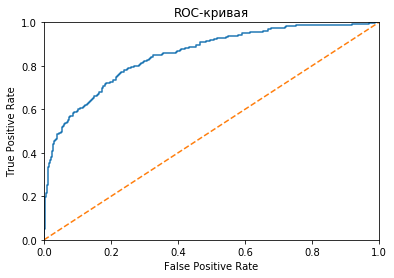

In [38]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)# < напишите код здесь >

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Значение метрики Auc-roc получили равным 0.86.  Если бы стояла задача максимизации этой метрики, то гиперпарметры возможно были бы другими. Как показало исследование максимальные значения метрик f1 и auc-roc достигаются при отличающихся значениях гиперпараметров.

**Общий вывод: в результате исследования моделей был выбран алгоритм RandomForestClassifier. Подбором гиперпарметров удалось достичь целевого значения метрики F1. После устранения дисбаланса классов удалось улучшить значение метрики F1 c 0.59 до 0.65. Финальное тестирование модели также прошло успешно, метрика f1  0.602.**